In [1]:
import os
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
# some global variables
filepath = '/home/lagvna/slncs/'
mp3_name = 'drilling.mp3'
wav_name = 'drilling.wav'
sample_frequency = 44100
chunk_size = 2048

In [4]:
# converting mp3 to mono wav
sound = AudioSegment.from_mp3(filepath + mp3_name)
sound = sound.set_channels(1)
sound.export(filepath + wav_name, format="wav")

<_io.BufferedRandom name='/home/lagvna/slncs/drilling.wav'>

# EDA

In [5]:
rate, data = wav.read('drilling.wav')

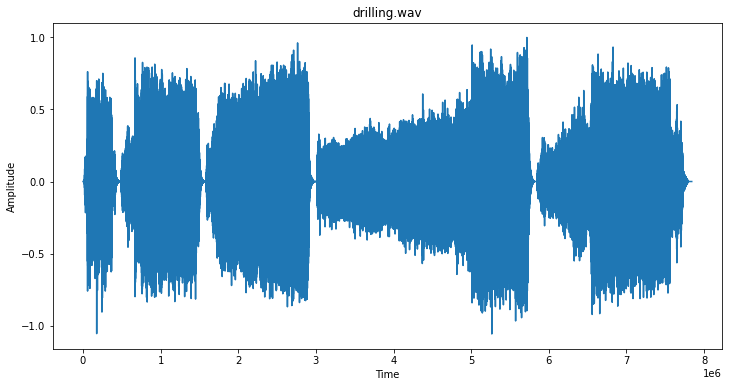

In [6]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data/np.max(data))
plt.title(wav_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [7]:
len(data)/rate

177.79045351473923

/home/lagvna/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


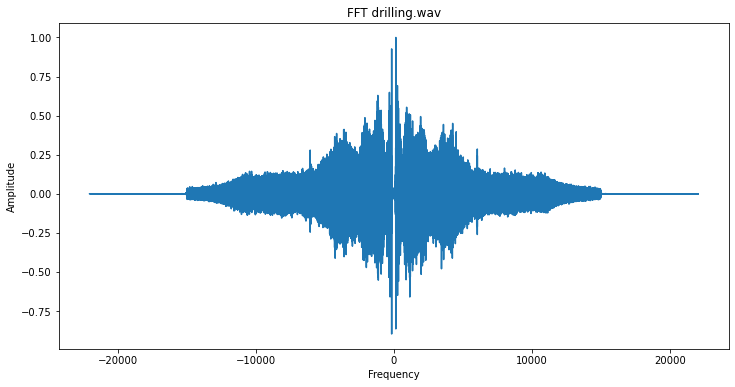

In [8]:
# fft
yf = fft(data)
yf = yf/np.max(yf)
xf = fftfreq(len(data), 1 / rate)

plt.figure(figsize=(12, 6))
plt.plot(xf, yf)
plt.title("FFT " + wav_name)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [9]:
len(data) / sample_frequency

177.79045351473923

In [10]:
# stft
f, t, Zxx = signal.stft(data, nperseg=512)

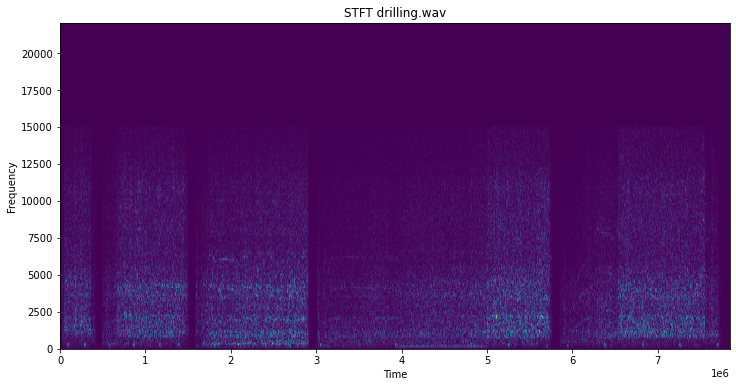

In [11]:
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f*sample_frequency, np.abs(Zxx), vmin=0, shading='flat')
plt.title("STFT "+wav_name)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

# Data preprocessing

In [12]:
def divide_data(recording, chunk_size):
    remainder = len(recording) % chunk_size
    padding_size = chunk_size - remainder
    padding_vector = np.zeros(padding_size)
    padded_recording = np.append(recording, padding_vector)
    chunks = np.split(padded_recording, len(padded_recording)/chunk_size)
    
    return chunks

In [13]:
def fftransform(recording_chunks):
    fft_chunks = []
    for c in recording_chunks:
        fft_chunk = fft(c)
        full_fft_chunk = np.concatenate((np.real(fft_chunk), np.imag(fft_chunk)))
        fft_chunks.append(full_fft_chunk)
    return fft_chunks

In [14]:
def inv_fftransform(fq_chunks):
    chunks = []
    for c in fq_chunks:
        midpoint = c.shape[0] / 2
        real_chunk = c[0:int(midpoint)]
        imag_chunk = c[int(midpoint):]
        # amplitude represented as a complex number corresponding to the frequency
        full_chunk = real_chunk + 1.0j * imag_chunk
        time_chunk = ifft(full_chunk)
        chunks.append(time_chunk)
    return chunks

In [15]:
normalized_data = data / 32767.0
data_chunks = divide_data(normalized_data, chunk_size)
#print(data_chunks)
X = fftransform(data_chunks)
Y = fftransform(data_chunks[1:])
print(np.shape(X))
print(np.shape(Y))

(3829, 4096)
(3828, 4096)


#### LSTM requires a 3D input in the form of (samples, timesteps, features) ->
https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [16]:
timestep = 50

In [17]:
# padding with zero vectors at the end, for an equal split
while len(X)%timestep != 0:
    X.append(np.zeros(np.shape(X)[1]))
    
while len(Y)%timestep != 0:
    Y.append(np.zeros(np.shape(Y)[1]))

In [18]:
# turning into np array to split examples equally into timesteps, then going back to a list
X = np.array(X)
tmp_x = np.split(X, X.shape[0]/timestep)
x_train = np.stack(tmp_x, axis = 0)

Y = np.array(Y)
tmp_y = np.split(Y, Y.shape[0]/timestep)
y_train = np.stack(tmp_y, axis = 0)

In [19]:
print(np.shape(x_train))
print(np.shape(y_train))

(77, 50, 4096)
(77, 50, 4096)


# Model design and training

In [20]:
NL = 1024

num_frequency_dimensions = (np.shape(X))[1]
a = (np.shape(x_train))[0]
b = (np.shape(x_train))[1]

model = Sequential()
model.add(TimeDistributed(Dense(NL, input_shape=(num_frequency_dimensions, ))))
model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
#model.add(Bidirectional(LSTM(NL, input_shape=(NL, ), return_sequences=True)))
model.add(TimeDistributed(Dense(num_frequency_dimensions, input_shape=(NL, ))))
#adam = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [21]:
model.build((a, b, num_frequency_dimensions))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (77, 50, 1024)            4195328   
_________________________________________________________________
bidirectional (Bidirectional (77, 50, 2048)            16785408  
_________________________________________________________________
bidirectional_1 (Bidirection (77, 50, 2048)            25174016  
_________________________________________________________________
time_distributed_1 (TimeDist (77, 50, 4096)            8392704   
Total params: 54,547,456
Trainable params: 54,547,456
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x_train, y_train, batch_size=10, epochs=60, verbose=1, validation_split=0.0)

Epoch 1/60
8/8 [==============================] - 52s 6s/step - loss: 14.9947
Epoch 2/60
8/8 [==============================] - 47s 6s/step - loss: 16.9030
Epoch 3/60
8/8 [==============================] - 46s 6s/step - loss: 15.7218
Epoch 4/60
8/8 [==============================] - 47s 6s/step - loss: 14.9466
Epoch 5/60
8/8 [==============================] - 47s 6s/step - loss: 15.9486
Epoch 6/60
8/8 [==============================] - 47s 6s/step - loss: 15.0488
Epoch 7/60
8/8 [==============================] - 47s 6s/step - loss: 14.1792
Epoch 8/60
8/8 [==============================] - 47s 6s/step - loss: 14.4475
Epoch 9/60
8/8 [==============================] - 47s 6s/step - loss: 13.0696
Epoch 10/60
8/8 [==============================] - 47s 6s/step - loss: 14.2601
Epoch 11/60
8/8 [==============================] - 47s 6s/step - loss: 13.3843
Epoch 12/60
8/8 [==============================] - 47s 6s/step - loss: 13.2933
Epoch 13/60
8/8 [==============================] - 47s 6s/ste

# Audio generation

In [27]:
seed = x_train[0]
gen_length = 50
# 1 sample with a no of timesteps and corresponding no of features
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))
#print(seed.shape)

output = []
for i in range(gen_length):
    generated_piece = model.predict(seed)
    #print(np.shape(generated_piece))
    if i == 0:
        for j in range(generated_piece.shape[1]):
            output.append(generated_piece[0][j].copy())
    else:
        #print(gen_piece[0][gen_piece.shape[1]-1])
        output.append(generated_piece[0][generated_piece.shape[1]-1].copy()) 
    
    new_seed = generated_piece[0][generated_piece.shape[1]-1]
    new_seed = np.reshape(new_seed, (1, 1, new_seed.shape[0]))
    seed = np.concatenate((seed, new_seed), axis=1)
    #print(np.shape(seed))
#print(output)

In [28]:
gen_file_path = '/home/lagvna/slncs/gen_sound.wav'
inv_output = inv_fftransform(output)
print(np.shape(output))
gen_file = np.concatenate(inv_output)
final_file = gen_file * 32767.0
final_file = final_file.astype('int16')
wav.write(gen_file_path, sample_frequency, final_file)

(99, 4096)


<ipython-input-28-77d1b581b38d>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  final_file = final_file.astype('int16')


In [29]:
Audio(gen_file_path)